<a href="https://colab.research.google.com/github/mohammedhemed77/NN-zero-to-hero-personal-practice/blob/master/micrograd/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

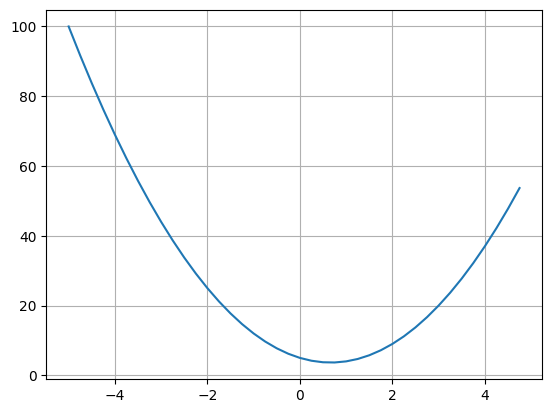

In [20]:
import numpy as np
import matplotlib.pyplot as plt 
def f(x):
    return 3*x**2 -4*x +5  

xs = np.arange(-5,5,0.25)
ys = f(xs)

plt.plot(xs,ys)
plt.grid(True)



In [19]:

# use f-format for debugging 
x = 100 
y = "aliaa"
# debug 
print (f"{x =},{y=}")     


x =100,y='aliaa'


revise zip and iterators 

In [21]:
list1 = (10 ,20,30)
list2 = ('a','b','c')

zipped = zip(list1,list2)
print (list(zipped)) 

list3 = ("ali","ahmed", "Alice")
list4 = (10 , 20 , 30 )

names_iter = iter(list3)
ages_iter  = iter(list4)

for name, age in zip(names_iter,ages_iter):
    print (f"{name} is {age} years old")


[(10, 'a'), (20, 'b'), (30, 'c')]
ali is 10 years old
ahmed is 20 years old
Alice is 30 years old


micro_grad Engine class

In [1]:
class Value :
 def __init__(self, data ,_childrwn= (), op='' ):
    self.data = data
    print("hello world")